In [13]:
#!/usr/bin/python

import pickle
import sys
import numpy
import matplotlib.pyplot as plt
import pandas as pd

sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from sklearn.model_selection import train_test_split
from tester import dump_classifier_and_data
from sklearn.cluster import KMeans
from time import time
from sklearn.metrics import accuracy_score
from sklearn import svm

In [14]:

###################### functions ##############################
def Draw(pred, features, poi, mark_poi=False, name="image.png", f1_name="feature 1", f2_name="feature 2"):
    """ some plotting code designed to help you visualize your clusters """

    ### plot each cluster with a different color--add more colors for
    ### drawing more than five clusters
    colors = ["b", "c", "k", "m", "g"]
    for ii, pp in enumerate(pred):
        plt.scatter(features[ii][0], features[ii][1], color = colors[pred[ii]])

    ### if you like, place red stars over points that are POIs (just for funsies)
    if mark_poi:
        for ii, pp in enumerate(pred):
            if poi[ii]:
                plt.scatter(features[ii][0], features[ii][1], color="r", marker="*")
    plt.xlabel(f1_name)
    plt.ylabel(f2_name)
    plt.savefig(name)
    plt.show()


###################### functions ##############################

******************** before oulier removal ***********************
('Co-rf/slope:', array([[1.65991868]]), 'Intercept: ', array([-0.09898831]))
('Score on Training Data : ', 0.5547517515697697)
('Score on Test Data : ', 0.09948499933237076)
*******************************************************************


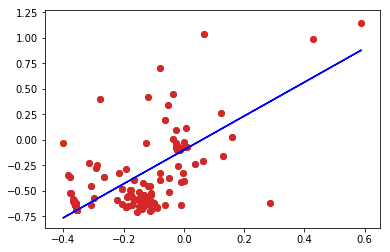

In [15]:
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ['poi','salary', 'total_payments', 'total_stock_value'] # You will need to use more features

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

### exploring the dataset ########
dataset = pd.DataFrame.from_dict(data_dict, orient='index')
#print(dataset)

dataset_new = dataset.dropna()
#print(dataset_new)

###### Number of POI = True is only 18 , and False is 28, though to take True and train the dataset
###### and predict the same on False dataset to find out any actual POI's but marked as False, but True is very less in number which is actually
###### not eligible for a training set.

data = featureFormat(data_dict, features_list)

##### preprocessing data #######
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(data)
scaler.mean_
data = scaler.transform(data)

###### still the same, very large margin between set of points to an outlier that is intercepting prediction ####

###### trying Normalizer ###########

from sklearn.preprocessing import Normalizer

transformer = Normalizer().fit(data)
data = transformer.transform(data)

##### better now ##################
outliers = []
salary = []
payplusstock = []

for point in data:
    poi = point[0]
    sal = point[1]
    salary.append(sal)
    pay = point[2] + point[3]
    payplusstock.append(pay)

    plt.scatter( sal, pay )
    outliers.append((int(sal),int(pay)))

import numpy
numpy.amax(data)

#pprint(sorted(outliers,key=lambda x:x[1],reverse=True)[:2])
salary = numpy.reshape( numpy.array(salary), (len(salary), 1))
payplusstock = numpy.reshape( numpy.array(payplusstock), (len(payplusstock), 1))

from sklearn.model_selection import train_test_split
salary_train, salary_test, payplusstock_train, payplusstock_test = train_test_split(salary, payplusstock, test_size=0.5, random_state=42)

from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(salary_train, payplusstock_train)

print("******************** before oulier removal ***********************")
print("Co-rf/slope:", reg.coef_, "Intercept: ", reg.intercept_)
print("Score on Training Data : ", reg.score(salary_train,payplusstock_train))
print("Score on Test Data : ", reg.score(salary_test,payplusstock_test))
print("*******************************************************************")


try:
    plt.plot(salary, reg.predict(salary), color="blue")
except NameError:
    pass
plt.scatter(salary, payplusstock)
plt.show()

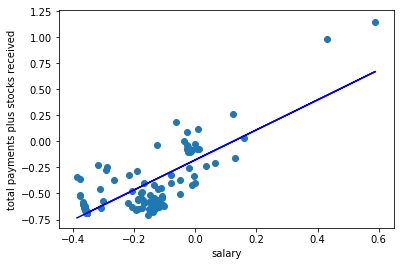

******************** after oulier removal ***********************
('Co-rf/slope:', array([[1.44146918]]), 'Intercept: ', array([-0.17791513]))
('Score on Training Data : ', 0.5353339843718562)
('Score on Test Data : ', 0.1845568860485427)
*******************************************************************


In [16]:
### Task 2: Remove outliers

from outlier_cleaner import outlierCleaner

cleaned_data = []

try:
    predictions = reg.predict(salary)
    cleaned_data = outlierCleaner( predictions, salary, payplusstock )
except NameError:
    print "your regression object doesn't exist, or isn't name reg"
    print "can't make predictions to use in identifying outliers"



### now checking if cleaned data has some thing or not ###
if len(cleaned_data) > 0:
    salary, payplusstock, errors = zip(*cleaned_data)
    salary  = numpy.reshape( numpy.array(salary), (len(salary), 1))
    payplusstock = numpy.reshape( numpy.array(payplusstock), (len(payplusstock), 1))

    ### refit your cleaned data!
    try:
        reg.fit(salary, payplusstock)
        plt.plot(salary, reg.predict(salary), color="blue")
    except NameError:
        print "you don't seem to have regression imported/created,"
        print "   or else your regression object isn't named reg"
        print "   either way, only draw the scatter plot of the cleaned data"
    plt.scatter(salary, payplusstock)
    plt.xlabel("salary")
    plt.ylabel("total payments plus stocks received")
    plt.show()

else:
    print "outlierCleaner() is returning an empty list, no refitting to be done"


print("******************** after oulier removal ***********************")
print("Co-rf/slope:", reg.coef_, "Intercept: ", reg.intercept_)
print("Score on Training Data : ", reg.score(salary_train,payplusstock_train))
print("Score on Test Data : ", reg.score(salary_test,payplusstock_test))
print("*******************************************************************")

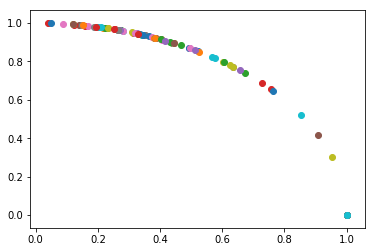

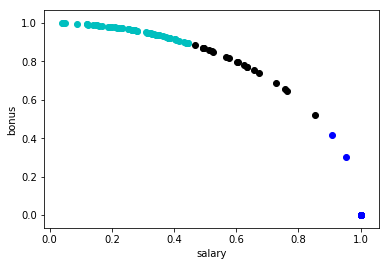

('features_list is ', ['poi', 'salary', 'bonus', 'sal_to_bonus_ratio'])


In [17]:
### Task 3: Create new feature(s)

###### check salary and bonus ratio to check if bonus is paid based up on salary to see if we can find out
###### any pattern in this
###### firstly using K-means Clustering

### the input features we use

feature_1 = "salary"
feature_2 = "bonus"
poi  = "poi"
features_list = [poi, feature_1, feature_2 ]
data = featureFormat(data_dict, features_list )

#### normalizing ######
transformer = Normalizer().fit(data)
data = transformer.transform(data)

poi, finance_features = targetFeatureSplit( data )


for f1, f2 in finance_features:
    plt.scatter( f1, f2 )
plt.show()


kmeans = KMeans(n_clusters = 3, random_state=0).fit(finance_features)
#print(kmeans.labels_)
pred = kmeans.predict(finance_features)


try:
    Draw(pred, finance_features, poi, mark_poi=False, name="clusters.pdf", f1_name=feature_1, f2_name=feature_2)
except NameError:
    print "no predictions object named pred found, no clusters to plot"


##### tried above by K-Means but did not give me any idea ...probably choosed wrong way....

##### creating new feature salary/bonus ratio ########
for v in data_dict.values():
    sal = v["salary"]
    bon  = v["bonus"]

    v["sal_to_bonus_ratio"] = (float(sal) / float(bon) if
                           sal not in [0, "NaN"] and bon
                           not in [0, "NaN"] else 0.0)

features_list.append("sal_to_bonus_ratio")
#features_list.remove("bonus")
#features_list.remove("salary")

### Store to my_dataset for easy export below.
my_dataset = data_dict

### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

print("features_list is ", features_list)

In [18]:
### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

# starting with GaussianNB classifier first to see
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

t0 = time()
clf.fit(features_train, labels_train)
print("training time for Gaussioan NB classifier :", round(time()-t0, 3), "s")

t1 = time()
pred = clf.predict(features_test)
print ("predicting time for Gaussioan NB classifier :", round(time()-t1, 3), "s")

accuracy = accuracy_score(pred,labels_test)
print("Accuracy  for Gaussioan NB classifier :" , accuracy)
print("length of features_train :", len(features_train))

### Storing classifier to my_classifier
my_classifier = clf
#### now SVM classifier
#### start with full traiing set....it has took lot of time but didn't finish so taking fractions of the data and training
#### setiing up fraction didnot work for me hence moving
#features_train = features_train[:len(features_train)/11]
#labels_train = labels_train[:len(labels_train)/11]
#print("length of features_train :", len(features_train))


#clf = svm.SVC(kernel='linear',gamma='auto')

#t0 = time()
#clf.fit(features_train,labels_train)
#print("training time for SVM classifier is :", round(time()-t0, 3), "s")

#t1 = time()
#pred = clf.predict(features_test)
#print ("predicting time for SVM classifier is :", round(time()-t1, 3), "s")

#accuracy = accuracy_score(pred,labels_test)
#print("Acuuracy time  for SVM classifier is :", accuracy)


#### using pipeline
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

pipeline_lr = Pipeline([('scalar1',StandardScaler()),
                        ('pca1', PCA(n_components=2)),
                        ('lr_classifier', LogisticRegression(random_state=0))])

pipeline_dt = Pipeline([('scalar2',StandardScaler()),
                        ('pca2', PCA(n_components=2)),
                        ('dt_classifier', DecisionTreeClassifier())])

pipeline_rf = Pipeline([('scalar3',StandardScaler()),
                        ('pca3', PCA(n_components=2)),
                        ('rf_classifier', RandomForestClassifier())])

pipelines = [pipeline_lr, pipeline_dt, pipeline_rf]

pipeline_dict = {0 : 'Linear Regression', 1 : 'Decision Tree Classifier', 2 : 'Random Forest Classifier'}

best_accuracy = 0.0
best_classifier = 0
best_pipeline = ""

### Applying fit method to all pipelines
for pipeline in pipelines:
    pipeline.fit(features_train, labels_train)
    #print(pipeline.get_params())

### now calculating accuracy for the three algorithm's in the pipelines
for index, model in enumerate(pipelines):
    print("{} accuracy is : {}".format(pipeline_dict[index], model.score(features_test, labels_test)))

### now finding out which yielded best results
for index, model in enumerate(pipelines):
    if  model.score(features_test, labels_test) >  best_accuracy:
        best_accuracy =  model.score(features_test, labels_test)
        best_classifier = index
        best_pipeline = model

print("Classifier with best accuracy is : {} with accuracy {} ".format(pipeline_dict[best_classifier],best_accuracy))


('training time for Gaussioan NB classifier :', 0.001, 's')
('predicting time for Gaussioan NB classifier :', 0.001, 's')
('Accuracy  for Gaussioan NB classifier :', 0.27586206896551724)
('length of features_train :', 66)
Linear Regression accuracy is : 0.689655172414
Decision Tree Classifier accuracy is : 0.620689655172
Random Forest Classifier accuracy is : 0.655172413793
Classifier with best accuracy is : Linear Regression with accuracy 0.689655172414 


In [19]:
# Task 5: Tune your classifier to achieve better than .3 precision and recall
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info:
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# Example starting point. Try investigating other evaluation techniques!

### now from above step we came to know that Linear Regression has given good accuracy, we will tune the same algorithm
### to maximize the accuracy

# Create an scaler object with get params from above
scalar1 = StandardScaler(copy=True, with_mean=True, with_std=True)

# Create a pca object with get params from above
pca1 = PCA(copy=True, iterated_power='auto', n_components=2, random_state=None, svd_solver='auto', tol=0.0, whiten=False)

# Create a logistic regression object with get params from above
lr_classifier = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1,
                              max_iter=100, multi_class='warn', n_jobs=None, penalty='l2', random_state=0,
                              solver='warn', tol=0.0001, verbose=0, warm_start=False)

# Create a pipeline
pipe = Pipeline(steps=[('scalar1', scalar1),
                       ('pca1', pca1),
                       ('lr_classifier', lr_classifier)])


### Create a list of a sequence of integers from 1 to 30 (the number of features in X + 1)
n_components = list(range(1,4,1))

### Create a list of values of the regularization parameter
C = numpy.logspace(-4, 4, 50)

### Create a list of options for the regularization penalty
penalty = ['l1', 'l2']

# Create a dictionary of all the parameter options
parameters = dict(pca1__n_components=n_components,
                  lr_classifier__C=C,
                  lr_classifier__penalty=penalty)
'''
parameters = {
    'lr_classifier__C' : [1.0],
    'scalar1__with_std' : [True],
    'scalar1__copy' : [True],
    'scalar1__with_mean' : [True],
    'pca1__random_state' : [None],
    'pca1__n_components' : [2],
    'pca1__iterated_power' : ['auto'],
    'pca1__tol' : [0.0],
    'pca1__svd_solver' : ['auto'],
    'pca1__whiten' : [False],
    'pca1__copy' : [True],
    'lr_classifier__max_iter' : [100],
    'lr_classifier__fit_intercept' : [True],
    'lr_classifier__multi_class' : ['warn'],
    'lr_classifier__dual' : [False],
    'lr_classifier__solver' : ['warn'],
    'lr_classifier__random_state' : [0],
    'lr_classifier__intercept_scaling' : [1],
    'lr_classifier__n_jobs' : [None],
    'lr_classifier__warm_start' : [False],
    'lr_classifier__verbose' : [0],
    'lr_classifier__tol' : [0.0001],
    'lr_classifier__penalty' : ['l2'],
    'lr_classifier__class_weight' : [None]
}
'''


from sklearn.model_selection import GridSearchCV
### Parameter Optmization With Pipeline
### Create a grid search object
clf = GridSearchCV(pipe, parameters)

### Fit the grid search
clf.fit(features_train, labels_train)


### View The Best Parameters
print('Best Penalty:', clf.best_estimator_.get_params()['lr_classifier__penalty'])
print('Best C:', clf.best_estimator_.get_params()['lr_classifier__C'])
print('Best Number Of Components:', clf.best_estimator_.get_params()['pca1__n_components'])

print(sorted(clf.cv_results_.keys()))


from sklearn.model_selection import cross_val_score
### Cross Validation To Evaluate Model
# Fit the grid search using 3-Fold cross validation
print(cross_val_score(clf, features, labels))

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: Deprecation

('Best Penalty:', 'l1')
('Best C:', 0.0001)
('Best Number Of Components:', 1)
['mean_fit_time', 'mean_score_time', 'mean_test_score', 'mean_train_score', 'param_lr_classifier__C', 'param_lr_classifier__penalty', 'param_pca1__n_components', 'params', 'rank_test_score', 'split0_test_score', 'split0_train_score', 'split1_test_score', 'split1_train_score', 'split2_test_score', 'split2_train_score', 'std_fit_time', 'std_score_time', 'std_test_score', 'std_train_score']
[0.8125     0.8125     0.83870968]


In [20]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, features_list)



